# Import

In [ ]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib

# Load Data

In [ ]:
# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

# Generator

In [ ]:
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(128,
                  kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    model.summary()
    return model

# Discriminator

In [ ]:
def Discriminator(input_dim, output_dim) -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    #model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(32, input_shape=(input_dim + output_dim, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    model.summary()
    return model

# WGAN GP

In [ ]:
class GAN():
    def __init__(self, generator, discriminator, input_dim, output_dim):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)
        
        self.discriminator_input = input_dim + output_dim

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        #alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        alpha = tf.random.normal([batch_size, self.discriminator_input, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0 or (epoch + 1) == epochs:
                tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
            
        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

# Train

In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]
epoch = 200

In [ ]:
input_dim

30

In [ ]:
feature_size

24

In [ ]:
output_dim

3

In [ ]:
generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 256)           216576    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 1

In [ ]:
discriminator = Discriminator(input_dim, output_dim)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 128)            24704     
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 220)               141020    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_7 (Dense)             (None, 220)              

epoch 15 d_loss 7.5403504 g_loss 0.027924392


epoch 30 d_loss 5.233882 g_loss -0.013823419


epoch 45 d_loss 2.0669317 g_loss 0.009561342


epoch 60 d_loss 0.13702351 g_loss 0.13570681


epoch 75 d_loss 0.07482947 g_loss 0.17120847


epoch 90 d_loss 0.06973244 g_loss 0.13184053


epoch 105 d_loss 0.054794177 g_loss 0.15320508


epoch 120 d_loss 0.04893855 g_loss 0.16443999


epoch 135 d_loss 0.04595163 g_loss 0.16892645


epoch 150 d_loss 0.03557054 g_loss 0.17975272


epoch 165 d_loss 0.0306624 g_loss 0.18195203


epoch 180 d_loss 0.027927283 g_loss 0.18814419


epoch 195 d_loss 0.02709981 g_loss 0.18772705


epoch 200 d_loss 0.026387822 g_loss 0.19268467


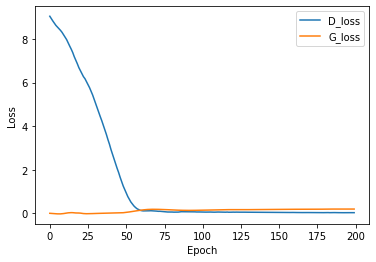

REAL (848, 3)
[[-0.94030462 -0.95328188 -0.95246226]
 [-0.95328188 -0.95246226 -0.95259887]
 [-0.95246226 -0.95259887 -0.949457  ]
 ...
 [ 0.17136808  0.17382692  0.15347312]
 [ 0.17382692  0.15347312  0.187897  ]
 [ 0.15347312  0.187897    0.19568335]]
PREDICTED (848, 3)
[[-1.0015036  -0.99060935 -1.0528018 ]
 [-0.97989804 -0.96865475 -1.0631797 ]
 [-0.98873276 -0.98834765 -1.048886  ]
 ...
 [ 0.19298579  0.23442717  0.31737837]
 [ 0.22336324  0.25032187  0.29054725]
 [ 0.19977409  0.24528942  0.30637202]]


<Figure size 432x288 with 0 Axes>

In [ ]:
gan = GAN(generator, discriminator, input_dim, output_dim)
Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)

# Plot Result

In [ ]:
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
print("----- predicted price -----", Predicted_price)

----- predicted price ----- [[-1.0015036  -0.99060935 -1.0528018 ]
 [-0.97989804 -0.96865475 -1.0631797 ]
 [-0.98873276 -0.98834765 -1.048886  ]
 ...
 [ 0.19298579  0.23442717  0.31737837]
 [ 0.22336324  0.25032187  0.29054725]
 [ 0.19977409  0.24528942  0.30637202]]


In [ ]:
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

In [ ]:
print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

----- rescaled predicted price ----- [[ 35.42993   36.227444  31.67464 ]
 [ 37.011566  37.83463   30.914928]
 [ 36.36482   36.39301   31.961306]
 ...
 [122.87253  125.90624  131.97868 ]
 [125.096306 127.06981  130.01451 ]
 [123.36946  126.70141  131.17296 ]]
----- SHAPE rescaled predicted price ----- (848, 3)


In [ ]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

Plot the predicted result

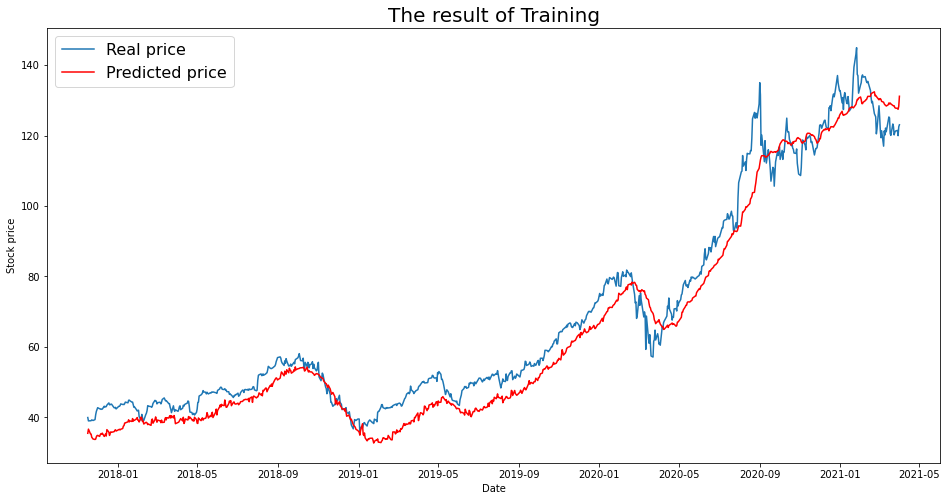

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("Predicted Mean", fontsize=20)
plt.show()
plt.savefig('train_plot.png')

Calculate RMSE

In [ ]:
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)

-- RMSE --  6.2072902547223965


In [ ]:
rescaled_Real_price_plots = np.swapaxes(rescaled_Real_price,0,1)
rescaled_Predicted_price_plots = np.swapaxes(rescaled_Predicted_price,0,1)

Predicted Price

In [ ]:
def PlotPredictedPrice(day, rescaled_Real_price_plots, rescaled_Predicted_price_plots, index, output_dim):
  reshaped_index = index[day:len(index) - (output_dim - 1 - day)]
  plt.figure(figsize=(16, 8))
  real_price["real_mean"].index.tolist()
  plt.plot(reshaped_index, rescaled_Real_price_plots[day])
  plt.plot(reshaped_index, rescaled_Predicted_price_plots[day], color = 'r')
  plt.xlabel("Date")
  plt.ylabel("Stock price")
  plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
  plt.title("Predicted Day " + str(day+1) + " Price", fontsize=20)
  plt.show()
  plt.savefig("predict_day" + str(day+1) + ".png")

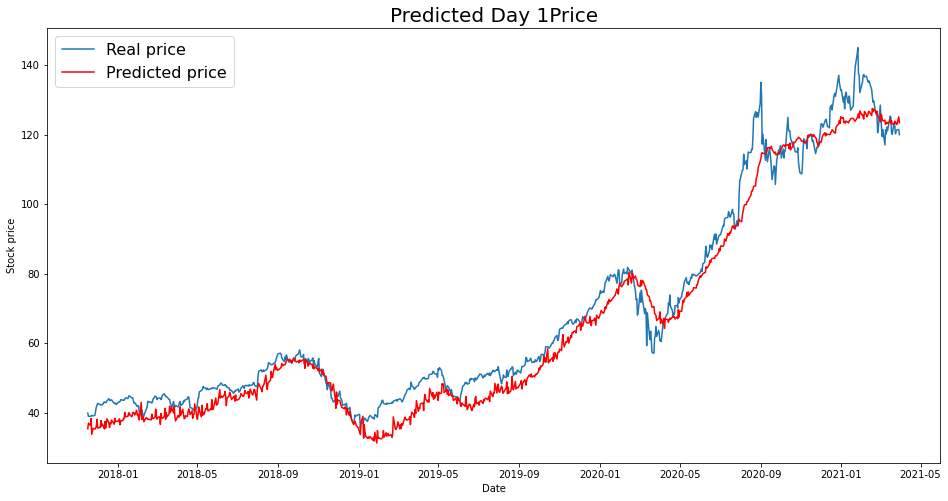

<Figure size 432x288 with 0 Axes>

In [ ]:
PlotPredictedPrice(0, rescaled_Real_price_plots, rescaled_Predicted_price_plots, real_price["real_mean"].index.tolist(), output_dim)

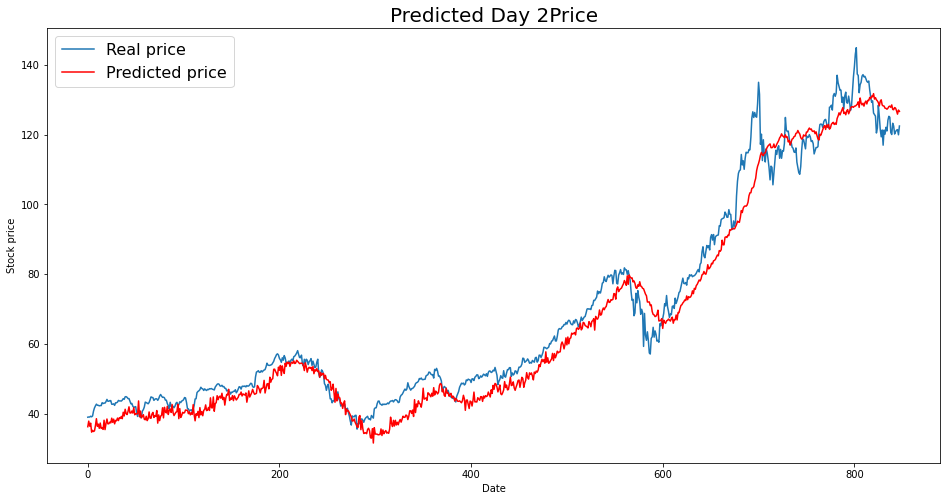

<Figure size 432x288 with 0 Axes>

In [ ]:
PlotPredictedPrice(1, rescaled_Real_price_plots, rescaled_Predicted_price_plots, real_price["real_mean"].index.tolist(), output_dim)

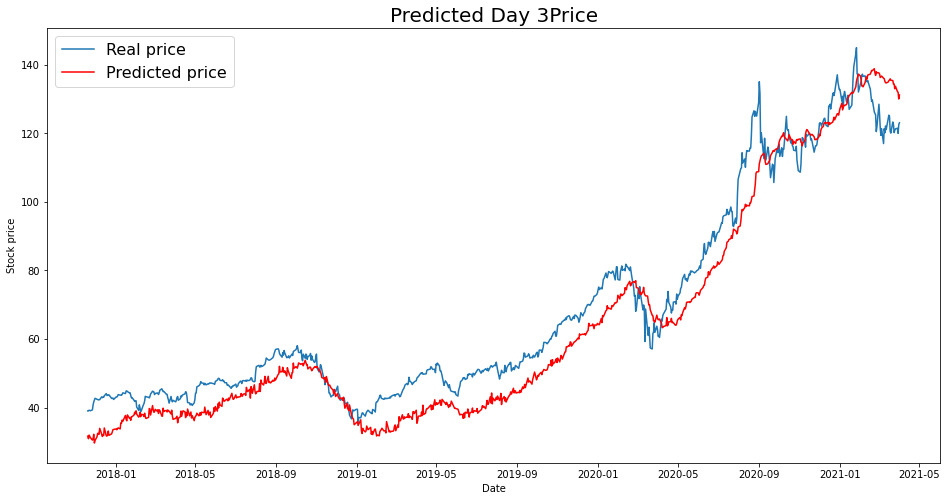

<Figure size 432x288 with 0 Axes>

In [ ]:
PlotPredictedPrice(2, rescaled_Real_price_plots, rescaled_Predicted_price_plots, real_price["real_mean"].index.tolist(), output_dim)